# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
Version = "7.2.1-Small-v3"                      # Used for tflite Filename
Testing_Percentage = 0.2                # 0.0 = Use all Images for Training
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 200

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, auc, cohen_kappa_score, classification_report
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

#### Importing useful functions
Useful functions to use in the notebook:
* plot_confusion_matrix: given a sklearn confusion matrix (cm), make a nice plot.

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [3]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Testing_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Testing_Percentage)
else:
    X_train = x_data
    y_train = y_data

if (Training_Percentage > 0):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=Training_Percentage)
else:
    X_train = X_train
    y_train = y_train

(817, 32, 20, 3)
(817, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [4]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [5]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_val, y_val, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_train, y_train, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 131 steps, validate for 33 steps
Epoch 1/200
131/131 [==============================] - 3s 23ms/step - loss: 1.9876 - accuracy: 0.4425 - val_loss: 2.0969 - val_accuracy: 0.4733

# Testing
The testing input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.
The accuracy and the confusion matrix of the testing process are illustrated. 

Accuracy: 0.8963414634146342
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.86      1.00      0.92         6
           2       0.89      1.00      0.94         8
           3       0.71      0.83      0.77         6
           4       1.00      0.79      0.88        14
           5       0.80      0.67      0.73         6
           6       0.89      0.80      0.84        10
           7       0.92      0.85      0.88        13
           8       1.00      0.85      0.92        13
           9       0.86      0.86      0.86         7
          10       0.91      0.96      0.93        71

    accuracy                           0.90       164
   macro avg       0.88      0.86      0.87       164
weighted avg       0.90      0.90      0.90       164



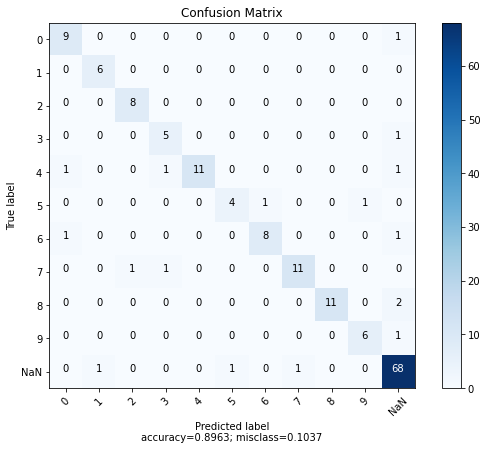

In [6]:
if (Testing_Percentage > 0):
    #class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]
    #test_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    #y_pred = model.predict_generator(test_iterator)
    y_pred = model.predict(X_test)
    print('Accuracy: ' + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))))
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    plot_confusion_matrix(cm           = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), 
                      normalize    = False,
                      target_names = subdir,
                      title        = "Confusion Matrix")
    

### Learing result
 
* Visualization of the training and validation results

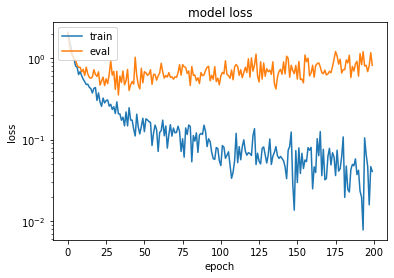

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

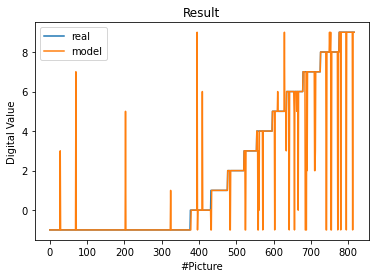

In [8]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [9]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

218400

In [10]:
FileName = "Train_CNN_Digital-Readout_Version_" + Version
# model.save(FileName + ".h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

218400

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [11]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/0\0Diego.jpg 0 NaN
ziffer_sortiert_resize/0\0Diego1.jpg 0 NaN
ziffer_sortiert_resize/0\D6_2020-08-16_01-02-52.jpg 0 9
ziffer_sortiert_resize/0\D6_2020-08-20_03-23-12.jpg 0 NaN
ziffer_sortiert_resize/0\digit8_053007.jpg 0 6
ziffer_sortiert_resize/1\1Diego.jpg 1 NaN
ziffer_sortiert_resize/1\1Diego2.jpg 1 NaN
ziffer_sortiert_resize/2\2Diego.jpg 2 NaN
ziffer_sortiert_resize/2\2Diego1.jpg 2 NaN
ziffer_sortiert_resize/3\3Diego.jpg 3 NaN
ziffer_sortiert_resize/3\3Diego1.jpg 3 NaN
ziffer_sortiert_resize/4\4Diego.jpg 4 NaN
ziffer_sortiert_resize/4\4Diego1.jpg 4 NaN
ziffer_sortiert_resize/4\4_a.jpg 4 3
ziffer_sortiert_resize/4\4_b.jpg 4 0
ziffer_sortiert_resize/4\D5_2020-08-20_17-24-21.jpg 4 NaN
ziffer_sortiert_resize/5\5Diego.jpg 5 NaN
ziffer_sortiert_resize/5\c1.jpg 5 6
ziffer_sortiert_resize/5\ziffer3_2020-04-24_16-40-06.jpg 5 9
ziffer_sortiert_resize/5\Ziffer_5_0140.jpg 5 3
ziffer_sortiert_resize/6\6Diego.jpg 6 NaN
ziffer_sortiert_resize/6\D6_2020-08-15_13-34-25.jpg 6 

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.